### Import Library

In [1]:
import itertools
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import resnet

### Load Image

Init variables

In [2]:
train_data_dir = 'datasetaugmented2/train/'
validation_data_dir = 'datasetaugmented2/val/'
test_data_dir = 'datasetaugmented2/test/'

img_width = 224
img_height = 224

input_shape = (img_width, img_height, 3)
input_shape

(224, 224, 3)

In [3]:
def read_image_dir_to_nparray(data_dir):
    x = []
    y = []
    i = 0
    
    # baca setiap folder
    for folder in os.listdir(data_dir):
        # baca tiap file
        for image_name in os.listdir(data_dir + folder):
            image = mpimg.imread(data_dir + folder + '/' + image_name)
            x.append(image)
            y.append(i)
        i += 1    
    
    # ubah kedalam numpy array
    x = np.array(x).astype('float32')    
    y = np.array(y).astype('uint8')        
    return x, y

In [4]:
x_train, y_train = read_image_dir_to_nparray(train_data_dir)
print(x_train.shape, y_train.shape)

(918, 224, 224, 3) (918,)


In [5]:
x_val, y_val = read_image_dir_to_nparray(validation_data_dir)
print(x_val.shape, y_val.shape)

(306, 224, 224, 3) (306,)


In [6]:
x_test, y_test = read_image_dir_to_nparray(test_data_dir)
print(x_test.shape, y_test.shape)

(306, 224, 224, 3) (306,)


### Create Image Pairs

In [7]:
def make_pairs(x, y):
    """Creates a tuple containing image pairs with corresponding label.

    Arguments:
        x: List containing images, each index in this list corresponds to one image.
        y: List containing labels, each label with datatype of `int`.

    Returns:
        Tuple containing two numpy arrays as (pairs_of_samples, labels),
        where pairs_of_samples' shape is (2len(x), 2,n_features_dims) and
        labels are a binary array of shape (2len(x)).
    """

    num_classes = max(y) + 1
    digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]

        # add a non-matching example
        label2 = random.randint(0, num_classes - 1)
        while label2 == label1:
            label2 = random.randint(0, num_classes - 1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]     

        pairs += [[x1, x2]]
        labels += [0]

    return np.array(pairs), np.array(labels).astype("float32")


# make train pairs
pairs_train, labels_train = make_pairs(x_train, y_train)

# make validation pairs
pairs_val, labels_val = make_pairs(x_val, y_val)

# make test pairs
pairs_test, labels_test = make_pairs(x_test, y_test)

In [8]:
pairs_train.shape, labels_train.shape

((1836, 2, 224, 224, 3), (1836,))

**Split every pairs**

In [9]:
x_train_1 = pairs_train[:, 0]
x_train_2 = pairs_train[:, 1]
x_train_1.shape

(1836, 224, 224, 3)

In [10]:
x_val_1 = pairs_val[:, 0]
x_val_2 = pairs_val[:, 1]
x_val_1.shape

(612, 224, 224, 3)

In [11]:
x_test_1 = pairs_test[:, 0]
x_test_2 = pairs_test[:, 1]
x_test_1.shape

(612, 224, 224, 3)

## Visualize pairs and their labels

In [12]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 28, 28).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        num_col: Int, number of images in one row - (default is 3)
                 For test and train respectively, it should not exceed 3 and 7.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """

    # Define num_row
    # If to_show % num_col != 0
    #    trim to_show,
    #       to trim to_show limit num_row to the point where
    #       to_show % num_col == 0
    #
    # If to_show//num_col == 0
    #    then it means num_col is greater then to_show
    #    increment to_show
    #       to increment to_show set num_row to 1
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    # `to_show` must be an integral multiple of `num_col`
    #  we found num_row and we have num_col
    #  to increment or decrement to_show
    #  to make it integral multiple of `num_col`
    #  simply set it equal to num_row * num_col
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):

        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.concat([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("Actual: {} | Predicted: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

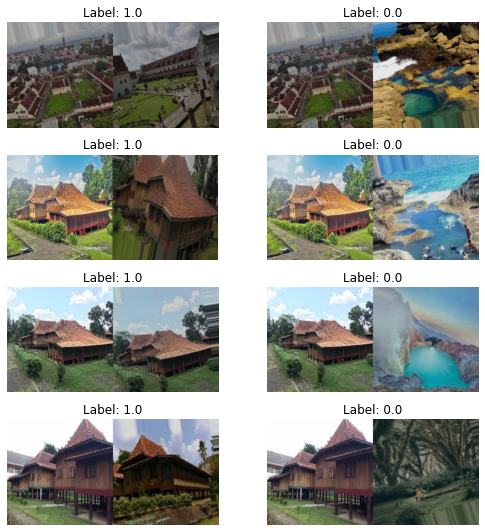

In [13]:
visualize(pairs_train[250:300], labels_train[250:300], to_show=8, num_col=2)

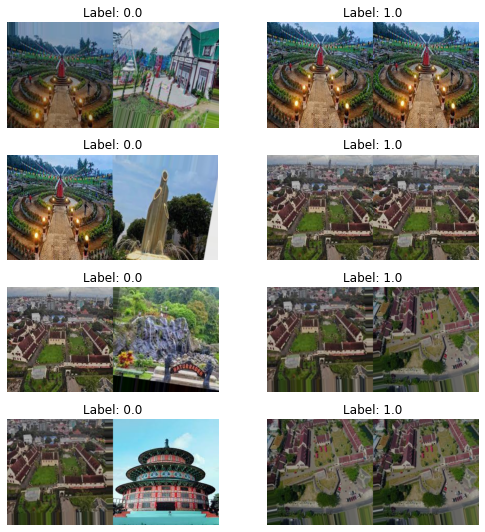

In [14]:
visualize(pairs_val[75:100], labels_val[75:100], to_show=8, num_col=2)

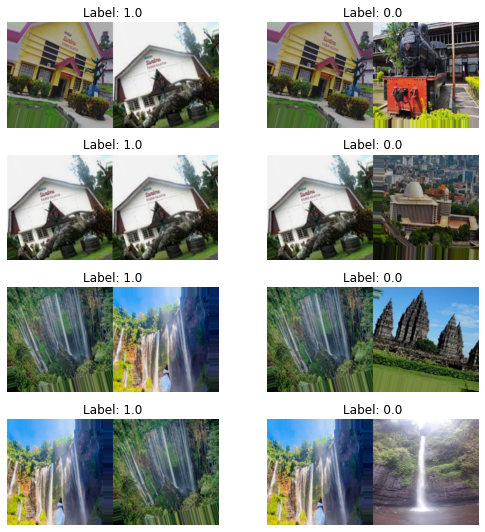

In [15]:
visualize(pairs_test[50:100], labels_test[50:100], to_show=8, num_col=2)

## Define the model

There are be two input layers, each leading to its own network, which
produces embeddings. A `Lambda` layer then merges them using an
[Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) and the
merged output is fed to the final network.

Available Pre Trained Model

https://keras.io/api/applications/#usage-examples-for-image-classification-models

This model using Fine Tuned Mobile net

https://deeplizard.com/learn/video/Zrt76AIbeh4

In [16]:
# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

In [17]:
input = layers.Input((224, 224, 3))
x = tf.keras.layers.BatchNormalization()(input)
x = layers.Conv2D(4, (5, 5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(16, (5, 5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)

x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(102, activation="tanh")(x)
embedding_network = keras.Model(input, x)


input_1 = layers.Input((224, 224, 3))
input_2 = layers.Input((224, 224, 3))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

## Define the constrastive Loss

In [18]:
def loss(margin=1):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

  Arguments:
      margin: Integer, defines the baseline for distance for which pairs
              should be classified as dissimilar. - (default is 1).

  Returns:
      'constrastive_loss' function with data ('margin') attached.
  """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the constrastive loss.

      Arguments:
          y_true: List of labels, each label is of type float32.
          y_pred: List of predictions of same length as of y_true,
                  each label is of type float32.

      Returns:
          A tensor containing constrastive loss as floating point value.
      """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss


## Compile the model with the contrastive loss

**Setup Hyperparameter**

In [19]:
epochs = 100
batch_size = 16
margin = 1  # Margin for constrastive loss.

In [20]:
# from tensorflow.keras import optimizers
# siamese.compile(loss=loss(margin=margin), optimizer=optimizers.Adam(0.0001), metrics=["accuracy"])
siamese.compile(loss=loss(margin=margin), optimizer="RMSprop", metrics=["accuracy"])
siamese.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 102)          4766098     ['input_2[0][0]',                
                                                                  'input_3[0][0]']          

In [21]:
dot_img_file = 'siamese_model.png'
tf.keras.utils.plot_model(siamese, to_file=dot_img_file, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


## Train the model

In [ ]:
history = siamese.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=batch_size,
    epochs=epochs,
)

Epoch 1/100
115/115 [==============================] - 32s 275ms/step - loss: 0.3061 - accuracy: 0.4009 - val_loss: 0.3710 - val_accuracy: 0.2958
Epoch 2/100
115/115 [==============================] - 32s 280ms/step - loss: 0.2829 - accuracy: 0.4232 - val_loss: 0.3304 - val_accuracy: 0.3415
Epoch 3/100
115/115 [==============================] - 34s 292ms/step - loss: 0.2684 - accuracy: 0.4455 - val_loss: 0.3027 - val_accuracy: 0.3562
Epoch 4/100
115/115 [==============================] - 34s 295ms/step - loss: 0.2648 - accuracy: 0.4379 - val_loss: 0.2867 - val_accuracy: 0.3611
Epoch 5/100
115/115 [==============================] - 35s 303ms/step - loss: 0.2591 - accuracy: 0.4330 - val_loss: 0.2722 - val_accuracy: 0.3644
Epoch 6/100
115/115 [==============================] - 36s 314ms/step - loss: 0.2546 - accuracy: 0.4379 - val_loss: 0.2637 - val_accuracy: 0.3693
Epoch 7/100
115/115 [==============================] - 36s 312ms/step - loss: 0.2529 - accuracy: 0.4368 - val_loss: 0.2580 -

## Visualize results

In [ ]:
def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the constrastive loss
plt_metric(history=history.history, metric="loss", title="Constrastive Loss")

## Evaluate the model

In [ ]:
results = siamese.evaluate([x_test_1, x_test_2], labels_test)
print("test loss, test acc:", results)

## Visualize the predictions

In [ ]:
predictions = siamese.predict([x_test_1, x_test_2])
visualize(pairs_test, labels_test, to_show=3, predictions=predictions, test=True)

In [ ]:
siamese.save_weights("model83.h5")